In [2]:
import pandas as pd
import os, sys
from sklearn.gaussian_process import GaussianProcessRegressor
import shapefile
from functools import partial
import pyproj
from shapely.geometry import shape, Point, mapping
from shapely.ops import transform
processeddir = "../data/processed/"
rawdir = "../data/raw/"
df = pd.read_csv(os.path.join(processeddir,"nyctaxiclean.csv"), dtype={"store_and_fwd_flag": "object"})

In [3]:
df["pickup_float"] = pd.to_datetime(df["pickup_datetime"]).apply(lambda x: x.timestamp())
df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"])
df["dropoff_datetime"] = pd.to_datetime(df["dropoff_datetime"])
df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"])
df["dropoff_datetime"] = pd.to_datetime(df["dropoff_datetime"])

In [4]:


def get_centroids(filename=rawdir+"taxi_zones/taxi_zones"):
    sf = shapefile.Reader(filename)

    project = partial(
        pyproj.transform,
        pyproj.Proj(init='epsg:2263', preserve_units=True), # NAD_1983_StatePlane_New_York_Long_Island_FIPS_3104_Feet
        pyproj.Proj(init='epsg:4326')) # wgs84 (lat/lng) 
 
    centroids = list(map(lambda x: transform(project, shape(x.__geo_interface__)).centroid, sf.shapes()))
    
    df = pd.DataFrame(sf.records())
    df = df.rename(columns={3:"name"})
    df["centroid_x"] = list(map(lambda x: x.x, centroids))
    df["centroid_y"] = list(map(lambda x: x.y, centroids))
    return df

In [5]:
df["pickup_hour"] = df["pickup_datetime"].apply(lambda x: x.hour)
df["pickup_dayofweek"] = df["pickup_datetime"].apply(lambda x: x.weekday())
df["pickup_dayofmonth"] = df["pickup_datetime"].apply(lambda x: x.day)


In [6]:
centroid_df = get_centroids()

In [13]:
# get 50 most significant neighbourhoods by demand as per 'describe data' notebook
demand = df.groupby("pickup_neighbourhood").count()

demand = demand.sort_values("medallion", ascending=False)

sig_demand = demand.iloc[:50]

sig_neighbourhoods = sig_demand.reset_index()["pickup_neighbourhood"]

# bunch all "other" neighbourhoods together as we're not modelling them separately
df.loc[~df["dropoff_neighbourhood"].isin(sig_neighbourhoods),"dropoff_neighbourhood"] = "OtherNYC"
sig_df = df[df["pickup_neighbourhood"].isin(sig_neighbourhoods)]



In [27]:
#group by day of month and day of week to get multiple values for each day of the week (ie) thursday
timebinning_key = ["pickup_hour", "pickup_dayofmonth", "pickup_dayofweek", "pickup_neighbourhood", "dropoff_neighbourhood"]
timebinned_grb = sig_df.groupby(timebinning_key)
timebinned_counts = timebinned_grb.count()
timebinned_std = timebinned_grb.std()
timebinned_med = timebinned_grb.median()
timebinned_mean = timebinned_grb.mean()

timebinned_stats = timebinned_std[["fare_amount", "tip_amount"]].join(
    timebinned_med[["fare_amount", "tip_amount"]], lsuffix="_stddev", rsuffix="_median").join(
        timebinned_mean[["fare_amount", "tip_amount"]], rsuffix="_mean")

In [29]:
timebinned_stats= timebinned_stats.rename(columns={"fare_amount":"fare_amount_mean", "tip_amount":"tip_amount_mean"})

In [35]:
pivot_key = ["pickup_hour", "pickup_dayofmonth", "pickup_dayofweek", "pickup_neighbourhood"]

demand_dataset = timebinned_counts.reset_index().pivot_table(index=pivot_key, columns="dropoff_neighbourhood", values="medallion").fillna(0)
fare_and_tip_dataset = timebinned_stats.reset_index().pivot_table(index=pivot_key, columns="dropoff_neighbourhood", values=["fare_amount_mean", "tip_amount_mean", "fare_amount_median", "tip_amount_median", "fare_amount_stddev", "tip_amount_stddev"]).fillna(0)


In [49]:
centroid_demand_dataset = demand_dataset.reset_index().merge(centroid_df, left_on="pickup_neighbourhood", right_on="name")
fare_and_tip_dataset.columns = [' '.join(col).strip() for col in fare_and_tip_dataset.columns.values]

centroid_fare_dataset = fare_and_tip_dataset.reset_index().merge(centroid_df, left_on="pickup_neighbourhood", right_on="name")

In [95]:
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
import numpy as np
from sklearn.metrics import mean_squared_error
#run k-fold cross-validation to test model;
#simply withold one week at a time, this model neglects linearity of time 
k = 4

#focus on 4 POC neighbourhoods -2 busy and 2 medium
chosen_neighbourhoods = ["Upper East Side South", "Midtown Center", "Flatiron", "JFK Airport"]
filtered_demand_dataset = centroid_demand_dataset[centroid_demand_dataset["pickup_neighbourhood"].isin(chosen_neighbourhoods)]
err = []
stds = []
preds = []
actuals = []
for fold in range(k):
    train_df = filtered_demand_dataset[(filtered_demand_dataset["pickup_dayofmonth"] < fold * 7) | (filtered_demand_dataset["pickup_dayofmonth"] >= (fold + 1) * 7)]
    test_df = filtered_demand_dataset[(filtered_demand_dataset["pickup_dayofmonth"] >= fold * 7) | (filtered_demand_dataset["pickup_dayofmonth"] < (fold + 1) * 7)]
    
    demand_gp = GaussianProcessRegressor(kernel=1.0 * RBF(length_scale=1) + 1.0 * WhiteKernel()) #rbf kernel w/ noise component
    demand_gp.fit(train_df[["centroid_x", "centroid_y", "pickup_dayofweek", "pickup_hour"]], train_df.iloc[:,4:-8])

    pred, std = demand_gp.predict(test_df[["centroid_x", "centroid_y", "pickup_dayofweek", "pickup_hour"]], return_std=True)

    err.append(mean_squared_error(test_df.iloc[:,4:-8], pred))
    preds.append(pred)
    actuals.append(test_df.iloc[:,4:-8])
    stds.append(std)
    

In [149]:
#check convergence of model
#MSE (not rmse)
print(err)

[16.131262543568308, 298.5532254965994, 16.0234701830634, 15.927504077023285]


In [108]:
#leaving out week 2 caused issues with convergence
print(stds)
#much larger standard deviations mean failure to converge; model is uncertain

[array([4.70691094, 4.70691094, 4.8584451 , ..., 4.70691094, 4.70691094,
       4.70691094]), array([17.27431492, 17.27431491, 17.2743149 , ..., 17.27431493,
       17.27431492, 17.27431491]), array([4.9356847 , 4.9356847 , 5.09432157, ..., 5.09432157, 4.9356847 ,
       4.9356847 ]), array([4.98001955, 4.98001955, 5.14003702, ..., 5.14003702, 4.98001955,
       4.98001955])]


In [133]:
len(stds[i])

2880

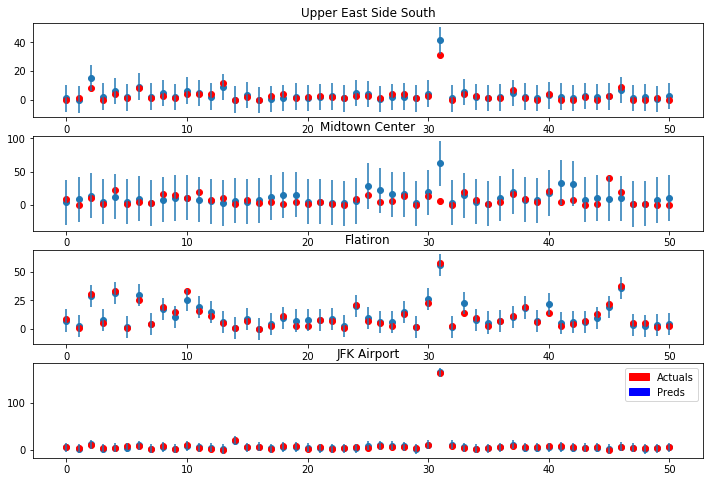

In [145]:
# %matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches


red_patch = mpatches.Patch(color='red', label='Actuals')
blue_patch = mpatches.Patch(color='blue', label='Preds')

import scipy.stats as ss
#plt.figure(figsize=(8,12))
#examine some example predictions
fig, ax = plt.subplots(4, figsize=(12,8))
plt.legend(handles=[red_patch, blue_patch])
step = 300

for i in range(k):
    ax[i].scatter(np.arange(len(preds[i][i*step])), preds[i][i*step])
    ax[i].set_title("{}".format(chosen_neighbourhoods[i]))
    ax[i].errorbar(np.arange(len(preds[i][i*step])), preds[i][i*step], fmt="none", yerr=1.96*stds[i][i*step])
    ax[i].scatter(np.arange(len(actuals[i].iloc[i*step])), actuals[i].iloc[i*step], color='red')

In [148]:
#neighbourhoods for above graphs
test_df.iloc[:,4:-8].columns

Index(['Battery Park City', 'Central Park', 'Clinton East', 'Clinton West',
       'East Chelsea', 'East Harlem South', 'East Village',
       'Financial District North', 'Flatiron', 'Garment District', 'Gramercy',
       'Greenwich Village North', 'Greenwich Village South', 'Hudson Sq',
       'JFK Airport', 'Kips Bay', 'LaGuardia Airport', 'Lenox Hill East',
       'Lenox Hill West', 'Lincoln Square East', 'Lincoln Square West',
       'Little Italy/NoLiTa', 'Lower East Side', 'Manhattan Valley',
       'Meatpacking/West Village West', 'Midtown Center', 'Midtown East',
       'Midtown North', 'Midtown South', 'Morningside Heights', 'Murray Hill',
       'OtherNYC', 'OutsideNYC', 'Penn Station/Madison Sq West', 'SoHo',
       'Stuy Town/Peter Cooper Village', 'Sutton Place/Turtle Bay North',
       'Times Sq/Theatre District', 'TriBeCa/Civic Center',
       'UN/Turtle Bay South', 'Union Sq', 'Upper East Side North',
       'Upper East Side South', 'Upper West Side North',
       'Uppe

In [186]:
#join preds back into test_df for last round for vis
test_df = filtered_demand_dataset[(filtered_demand_dataset["pickup_dayofmonth"] >= fold * 7) | (filtered_demand_dataset["pickup_dayofmonth"] < (fold + 1) * 7)]
melted_test_df = test_df.drop("pickup_dayofmonth", axis=1)
len(preds[-1][0])
pred_df = pd.DataFrame(preds[-1])
pred_df.columns = test_df.iloc[:,4:-8].columns
pred_df.index = test_df.index
#test_df = test_df[["pickup_hour", "pickup_dayofweek", "pickup_neighbourhood"]]
melted_pred_df = pd.melt(pred_df, value_name="Predicted")
melted_test_df = pd.melt(melted_test_df, id_vars=["pickup_hour", "pickup_dayofweek", "pickup_neighbourhood"], value_name="Actual")

joined_pred_df = melted_test_df.join(melted_pred_df, rsuffix="pred")
joined_pred_df = joined_pred_df.rename(columns={"variable":"dropoff_neighbourhood"})
joined_pred_df = joined_pred_df.merge(centroid_df, left_on="dropoff_neighbourhood", right_on="name")
joined_pred_df

,pickup_hour,pickup_dayofweek,pickup_neighbourhood,dropoff_neighbourhood,Actual,variablepred,Predicted,0,1,2,name,4,5,centroid_x,centroid_y
0,0,0,Flatiron,Battery Park City,0,Battery Park City,0.742729,13,0.050281,0.000149,Battery Park City,13,Manhattan,-74.016079,40.712038
1,0,1,Flatiron,Battery Park City,1,Battery Park City,1.237881,13,0.050281,0.000149,Battery Park City,13,Manhattan,-74.016079,40.712038
2,0,2,Flatiron,Battery Park City,0,Battery Park City,2.303268,13,0.050281,0.000149,Battery Park City,13,Manhattan,-74.016079,40.712038
3,0,3,Flatiron,Battery Park City,4,Battery Park City,2.961344,13,0.050281,0.000149,Battery Park City,13,Manhattan,-74.016079,40.712038
4,0,4,Flatiron,Battery Park City,2,Battery Park City,3.948459,13,0.050281,0.000149,Battery Park City,13,Manhattan,-74.016079,40.712038
5,0,5,Flatiron,Battery Park City,4,Battery Park City,3.948459,13,0.050281,0.000149,Battery Park City,13,Manhattan,-74.016079,40.712038
6,0,6,Flatiron,Battery Park City,8,Battery Park City,5.264612,13,0.050281,0.000149,Battery Park City,13,Manhattan,-74.016079,40.712038
7,0,0,Flatiron,Battery Park City,2,Battery Park City,0.742729,13,0.050281,0.000149,Battery Park City,13,Manhattan,-74.016079,40.712038
8,0,1,Flatiron,Battery Park City,2,Battery Park City,1.237881,13,0.050281,0.000149,Battery Park City,13,Manhattan,-74.016079,40.712038
9,0,2,Flatiron,Battery Park City,5,Battery Park City,2.303268,13,0.050281,0.000149,Battery Park City,13,Manhattan,-74.016079,40.712038


In [211]:
#visualize last round of cross validation - leaving out week 4
import dash
import dash_core_components as dcc
from plotly.graph_objs import *
os.environ['WERKZEUG_RUN_MAIN'] = 'true'

colorscale = [
    'rgb(193, 193, 193)',
    'rgb(239,239,239)',
    'rgb(195, 196, 222)',
    'rgb(144,148,194)',
    'rgb(101,104,168)',
    'rgb(65, 53, 132)'
]

friday = joined_pred_df[joined_pred_df["pickup_dayofweek"]==4]
fri_midday = friday[friday["pickup_hour"]==12]
fri_6pm = friday[friday["pickup_hour"]==18]
fri_10pm = friday[friday["pickup_hour"]==22]
neighbourhood = "Midtown Center"
display_df = fri_midday[fri_midday["pickup_neighbourhood"] == neighbourhood]
app = dash.Dash()
data=[dict(
        type = 'scattermapbox',
        lon = display_df['centroid_x'],
        lat = display_df['centroid_y'],
        mode = 'markers',
        marker = dict(
            size = display_df["Predicted"]/5,
            opacity = 0.8,
            reversescale = False,
            autocolorscale = False,
            symbol = 'circle',
            colorscale = colorscale,
            cmin = 0,
            color = display_df["Predicted"],
            cmax = display_df["Predicted"].max(),
            colorbar=dict(
                title="Predicted demand (dropoff location)"
            )
        )),
     dict(
        type = 'scattermapbox',
        lon = centroid_df[centroid_df['name'] == neighbourhood]["centroid_x"],
        lat = centroid_df[centroid_df['name'] == neighbourhood]['centroid_y'],
        mode = 'markers',
        marker = dict(
            size = 7,
            opacity = 1,
            symbol = 'square',
            color = 'black',
            colorbar=dict(
                title=neighbourhood
            )
        ))]
    

app.layout = dcc.Graph(
    id = "mapbox",
    
    figure={
        "data": data,
        "layout": dict(
            hovermode = "closest",
            margin = dict(l = 0, r = 0, t = 0, b = 0),
            mapbox = dict(
                accesstoken = "pk.eyJ1IjoiZGVzdWx0aXIiLCJhIjoiY2pmZDN4M2FlMTEzYjJ3bWlyc2VhaDkxaiJ9.VvezwDLTQlh2GVAEsauwlg",
                bearing = 0,
                center = dict(lat=joined_pred_df["centroid_y"].iloc[-1], lon=joined_pred_df["centroid_x"].iloc[-1]),
                style = "light",
                pitch = 0,
                zoom = 10.0,
            )
        )
    },
    style = {"height": 750}
)

app.run_server(host="0.0.0.0", port=8001)

 * Running on http://0.0.0.0:8001/ (Press CTRL+C to quit)
10.4.143.59 - - [02/May/2018 18:44:06] "GET / HTTP/1.1" 200 -
10.4.143.59 - - [02/May/2018 18:44:09] "GET /_dash-dependencies HTTP/1.1" 200 -
10.4.143.59 - - [02/May/2018 18:44:09] "GET /_dash-layout HTTP/1.1" 200 -
10.4.143.59 - - [02/May/2018 18:44:09] "GET /favicon.ico HTTP/1.1" 200 -
